### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3 - Дерево решений


**Общая информация**

**Срок сдачи:** 3 мая 2021, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 03 мая, -4 балла после 08:30 10 мая, -6 баллов после 08:30 17 мая, -8 баллов после 08:30 24 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0221, Задание 3] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Реализуем дерево решений (3 балла)

Допишите недостающие части дерева решений. Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn.
Внимание: если Вас не устраивает предложенная структура хранения дерева, Вы без потери баллов можете сделать свой класс DecisionTreeClassifier, в котором сами полностью воспроизведете алгоритм дерева решений. Обязательно в нем иметь только функции fit, predict

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier


In [2]:
from sklearn.base import BaseEstimator, ClassifierMixin
class MyDecisionTreeClassifier(BaseEstimator, ClassifierMixin):
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1
    EPS = 10e-8

    def __init__(self, min_samples_split=2, max_depth=5, criterion='gini'):
        """
        criterion -- критерий расщепления. необходимо релизовать три:
        Ошибка классификации, Индекс Джини, Энтропийный критерий
        max_depth -- максимальная глубина дерева
        min_samples_split -- минимальное число объектов в листе, чтобы сделать новый сплит
        """
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_class = -1
        # Для последнего задания
        self.feature_importances_ = None
        self.criterion = criterion
        # Структура, которая описывает дерево
        # Представляет словарь, где для  node_id (айдишник узла дерева) храним
        # (тип_узла, айдишник признака сплита, порог сплита) если тип NON_LEAF_TYPE
        # (тип_узла, предсказание класса, вероятность класса) если тип LEAF_TYPE
        # Подразумевается, что у каждого node_id в дереве слева 
        # узел с айди 2 * node_id + 1, а справа 2 * node_id + 2
        self.tree = dict()

    def __div_samples(self, x, y, feature_id, threshold):
        """
        Разделяет объекты на 2 множества
        x -- матрица объектов
        y -- вектор ответов
        feature_id -- айдишник признака, по которому делаем сплит
        threshold -- порог, по которому делаем сплит
        """
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]
    
    def __class_error(self, p):
        return 1 - np.maximum(p, 1. - p)
    
    def __Gini_index(self, p):
        return p * (1 - p)
    
    def __entropy_loss(self, p):
        return -p * np.log(p + self.EPS) - (1 - p) * np.log(1 - p + self.EPS)

    def __find_threshold(self, x, y):
        """
        Находим оптимальный признак и порог для сплита
        Здесь используемые разные impurity в зависимости от self.criterion
        """
        y_feature = np.transpose(np.tile(y, x.shape[1]).reshape(y.shape[0], -1))
        feature_sorted_x = np.argsort(x, axis=0)
        x_sorted = np.sort(x, axis=0)
        y_sorted = y[feature_sorted_x]
        
        N_left = np.arange(y.shape[0]) + 1
        N_right = y.shape[0] - N_left + 1
        
        N_left = N_left[:, np.newaxis]
        N_right = N_right[:, np.newaxis]
        
        class_n_left = np.cumsum(y_sorted, axis=0)
        class_n_right = np.sum(y) - class_n_left
        p_left = class_n_left / N_left
        p_right = class_n_right / N_right
        p = np.sum(y) / y.shape[0]
        
        if self.criterion == 'gini':
            Q = -self.__Gini_index(p_left) * N_left / y.shape[0] - self.__Gini_index(p_right) * N_right / y.shape[0]
            Q += p * (1 - p)
        elif self.criterion == 'class':
            Q = -self.__class_error(p_left) * N_left / y.shape[0] - self.__class_error(p_right) * N_right / y.shape[0]
            Q += 1 - np.max([p, 1 - p])
        elif self.criterion == 'entropy':
            Q = -self.__entropy_loss(p_left) * N_left / y.shape[0] - self.__entropy_loss(p_right) * N_right / y.shape[0]
            Q -= p * np.log(p) + (1 - p) * np.log (1 - p + self.EPS)
        Q = np.nan_to_num(Q, nan=-np.inf)
        if Q.size == 0:
            return 0, np.inf
        ind = np.unravel_index(np.argmax(Q), Q.shape)
        self.feature_importances_[ind[1]] += Q[ind[0]][ind[1]]
        return ind[1], x_sorted[ind[0]][ind[1]]
        

    def __fit_node(self, x, y, node_id, depth):
        """
        Делаем новый узел в дереве
        Решаем, терминальный он или нет
        Если нет, то строим левый узел  с айди 2 * node_id + 1
        И правый узел с  айди 2 * node_id + 2
        """
        classes, counts = np.unique(y, return_counts=True)
        p = counts / y.shape[0]
        p_max_arg = p.argmax()
        y_pred = classes[p_max_arg]
        y_p = p[p_max_arg]
        
        if depth == self.max_depth or x.shape[0] <= self.min_samples_split or np.allclose(y_p, 1):
            self.tree[node_id] = (self.LEAF_TYPE, y_pred, y_p)
        else:
            f_id, thresh = self.__find_threshold(x, y)
            self.tree[node_id] = (self.NON_LEAF_TYPE, f_id, thresh)
            x_left, x_right, y_left, y_right = self.__div_samples(x, y, f_id, thresh)
            if not x_left.size or not x_right.size:
                self.tree[node_id] = (self.LEAF_TYPE, y_pred, y_p)
            else:
                self.__fit_node(x_left , y_left, node_id * 2 + 1, depth + 1)
                self.__fit_node(x_right, y_right, node_id * 2 + 2, depth + 1)
    
    def fit(self, x, y):
        """
        Рекурсивно строим дерево решений
        Начинаем с корня node_id 0
        """
        self.num_class = np.unique(y).size
        self.feature_importances_ = np.zeros(x.shape[1])
        self.__fit_node(x, y, 0, 0) 

    def __predict_class(self, x, node_id):
        """
        Рекурсивно обходим дерево по всем узлам,
        пока не дойдем до терминального
        """
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]
        
    def predict(self, X):
        """
        Вызывает predict для всех объектов из матрицы X
        """
        return np.array([self.__predict_class(x, 0) for x in X])
    
    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)
    
    def get_feature_importance(self):
        """
        Возвращает важность признаков
        """
        return self.feature_importances_

In [3]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)

In [4]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [5]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [6]:
accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

1.0

In [7]:
accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

0.9444444444444444

In [8]:
my_clf.get_feature_importance()

array([-2.22044605e-16,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  3.84969536e-01,  0.00000000e+00,
        0.00000000e+00,  6.63265306e-02,  1.45555405e-01,  0.00000000e+00,
        2.05666998e-01])

## Ускоряем дерево решений (2 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine. 
Для этого используем numpy.

In [9]:
%time clf.fit(X_train, y_train)

CPU times: user 6.06 ms, sys: 773 µs, total: 6.83 ms
Wall time: 4.18 ms


DecisionTreeClassifier()

In [10]:
%time my_clf.fit(X_train, y_train)

CPU times: user 16.9 ms, sys: 269 µs, total: 17.2 ms
Wall time: 14 ms


$$ 7.01 * 10 = 70.1 ms > 17.4 ms $$

## Боевое применение (3 балла)

На практике Вы познакомились с датасетом Speed Dating Data. В нем каждая пара в быстрых свиданиях характеризуется определенным набором признаков. Задача -- предсказать, произойдет ли матч пары (колонка match). 

Пример работы с датасетом можете найти в практике пункт 2
https://github.com/VVVikulin/ml1.sphere/blob/master/2019-09/lecture_06/pract-trees.ipynb

Данные и описания колонок лежат тут
https://cloud.mail.ru/public/8nHV/p6J7wY1y1/speed-dating-experiment/

Скачайте датасет, обработайте данные, как показано на семинаре или своим собственным способом. Обучите дерево классифкации. В качестве таргета возьмите колонку 'match'. Постарайтесь хорошо обработать признаки, чтобы выбить максимальную точность. Если точность будет близка к случайному гаданию, задание не будет защитано. 


In [11]:
from sklearn.model_selection import validation_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier

In [12]:
df = pd.read_csv('./Speed Dating Data.csv', encoding='latin1')
df.head()

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
4,1,1.0,0,1,1,1,10,7,NaN,7,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN


In [13]:
for col in df.columns:
    if (type(df[col][0]) != np.float64 and type(df[col][0]) != np.int64 and type(df[col][0]) != float):
        df.drop(col, axis=1, inplace=True)
for col in df.columns:
    if np.sum(df[col].isnull()) > 1000:
        df.drop(col, axis=1, inplace=True)

In [14]:
df = df.drop(['age_o', 'race_o', 'pf_o_att',
              'pf_o_sin', 'pf_o_int', 'pf_o_fun',
              'pf_o_amb', 'pf_o_sha', 'attr_o', 'sinc_o'], axis=1)

In [15]:
df = df.fillna(-500000)
y = df.loc[:, 'match'].values
df.drop(['match','dec','dec_o','like_o', 'like'], axis=1, inplace=True)
x = df.values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [16]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)

In [17]:
clf.fit(x_train, y_train)
my_clf.fit(x_train, y_train)

Разбейте датасет на трейн и валидацию. Подберите на валидации оптимальный критерий  информативности. 
Постройте графики зависимости точности на валидации от глубины дерева, от минимального числа объектов для сплита. 
Какой максимальной точности удалось достигнуть?

In [18]:
from sklearn.model_selection import cross_val_score

In [19]:
for i in ['class', 'entropy', 'gini']:
    my_clf = MyDecisionTreeClassifier(min_samples_split=2, criterion=i)
    print(f"{i} classifier: {cross_val_score(my_clf, x_train, y_train, cv=5, scoring='accuracy').mean()}")

class classifier: 0.8348255367458013
entropy classifier: 0.8422846617026722
gini classifier: 0.8437760860128887


In [20]:
max_score = 0
minSplit = []
splitScore = []
for i in range(2, 100):
    my_clf = MyDecisionTreeClassifier(min_samples_split=i, criterion='gini')
    score = cross_val_score(my_clf, x_train, y_train, cv=4, scoring='accuracy').mean()
    minSplit.append(i)
    splitScore.append(score)
    if score > max_score:
        max_score = score
        best_split = i


In [21]:
print(f"Max score {max_score} achieved with {best_split} minimum sample split")

Max score 0.8391516759876038 achieved with 75 minimum sample split


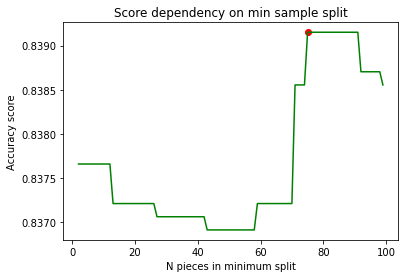

In [22]:
plt.plot(minSplit, splitScore, c='green')
plt.title("Score dependency on min sample split")
plt.xlabel("N pieces in minimum split")
plt.ylabel("Accuracy score")
_ = plt.scatter(best_split, max_score, c='red')

In [23]:
max_score = 0
best_depth = 0
maxDepth = []
depthScore = []
for i in range(1, 100):
    my_clf = MyDecisionTreeClassifier(max_depth=i, min_samples_split=best_split, criterion='gini')
    score = cross_val_score(my_clf, x_train, y_train, cv=4, scoring='accuracy').mean()
    maxDepth.append(i)
    depthScore.append(score)
    if score > max_score:
        max_score = score
        best_depth = i

In [24]:
print(f"Max score {max_score} achieved with {best_depth} max depth")

Max score 0.8391516759876038 achieved with 5 max depth


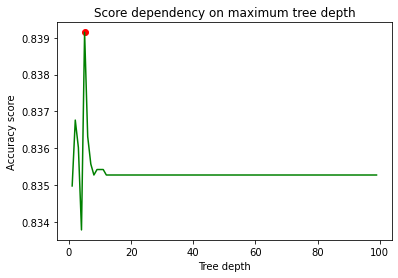

In [25]:
plt.plot(maxDepth, depthScore, c='green')
plt.title("Score dependency on maximum tree depth")
plt.xlabel("Tree depth")
plt.ylabel("Accuracy score")
_ = plt.scatter(best_depth, max_score, c='red')

## Находим самые важные признаки (2 балла)



По построенному дереву  легко понять, какие признаки лучше всего помогли решить задачу. Часто это бывает нужно  не только  для сокращения размерности в данных, но и для лучшего понимания прикладной задачи. Например, Вы хотите понять, какие признаки стоит еще конструировать -- для этого нужно понимать, какие из текущих лучше всего работают в дереве. 

Самый простой метод -- посчитать число сплитов, где использовался данные признак. Это не лучший вариант, так как по признаку который принимает всего 2 значения, но который почти точно разделяет выборку, число сплитов будет очень 1, но при этом признак сам очень хороший. 
В этом задании предлагается для каждого признака считать суммарный gain (в лекции обозначено как Q) при использовании этого признака в сплите. Тогда даже у очень хороших признаков с маленьким число сплитов это значение должно быть довольно высоким.  

Реализовать это довольно просто: создаете словарь номер фичи : суммарный гейн и добавляете в нужную фичу каждый раз, когда используете ее при построении дерева. 

Добавьте функционал, который определяет значения feature importance. Обучите дерево на датасете Speed Dating Data.
Выведите 10 главных фичей по важности.

In [26]:
from sklearn.metrics import accuracy_score
my_clf = MyDecisionTreeClassifier(max_depth=best_depth, min_samples_split=best_split, criterion='gini')
my_clf.fit(x_train, y_train)
print(f"Acc: {accuracy_score(my_clf.predict(x_test), y_test)}")

Acc: 0.8430787589498807


In [27]:
best_features = np.argsort(my_clf.get_feature_importance())[-10:]
print(f"""Best features : {best_features}
Importances   : {np.sort(my_clf.get_feature_importance())[-10:]}""")

Best features : [24 64 65 40 47 82 62 67 14 16]
Importances   : [0.00295106 0.00311981 0.0123387  0.0134843  0.01776966 0.02162074
 0.02476617 0.02769393 0.02810517 0.03053806]


## Фидбек (бесценно)

* Какие аспекты обучения деревьев решений Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

Все норм объясняли. Единственное, что можно было бы более подробно рассказать именно о подборе threshold, так как этот момент наиболее вариативен и можно чет напутать.

### ВАШ ОТЗЫВ ЗДЕСЬ



Хорошее ДЗ. Не супер сложное, но и не тривиальное:)